In [ ]:
%matplotlib inline

# Iris/dask dataset processing investigation

## Introduction

This demos using dask functionality beyond the `array` module to help with Iris processing. Specifically, in this notebook we will demo alternative approaches for loading numerous and/or large datasets into Iris.

Three approaches will be compared:

* The standard Iris load
* ~~Wrapping Iris load calls in a **dask bag** generated from a sequence (this is slow so will not be investigated further)~~
* Wrapping Iris load calls in a **dask bag** generated from a **delayed** call

These options will be compared with two simple metrics:

- Ease of use
- Runtime

## Setup

Below are the functions used to load the dataset. There is one function for each of the standard Iris load and the bag generated from a sequence. The bag generated from a delayed call requires two functions; one which is delayed, one to call the delayed function.

### Imports

In [1]:
import os
import time

import dask
import dask.array as da
import dask.bag as db
import dask.delayed as delayed
import iris

### Dask processing options

Define options on how dask is to process computation of graphs. Choose one of these!

In [ ]:
from multiprocessing.pool import ThreadPool

dask.set_options(pool=ThreadPool(8))

In [2]:
from distributed import Client

host_subnet = 22
s = '10.154.1.{}:8776'.format(host_subnet)

client = Client(s)

In [3]:
print dask.context._globals

defaultdict(<function <lambda> at 0x7f7c0c4959b0>, {'callbacks': set([]), 'shuffle': 'tasks', 'get': <bound method Client.get of <Client: scheduler="10.154.1.22:8776" processes=8 cores=8>>})


### Loader function

In [4]:
def delay_load(fp, seq):
    dlyds = [delayed(iris.load)(os.path.join(fp, pattern)) for pattern in seq]
    cs = db.from_delayed(dlyds)
    return iris.cube.CubeList(cs.compute())

## Test!

Run each loader on some sample data and print the output.

Using **sample PP data** at `/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z`:

In [5]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z'
fn = '*.pp'
seq = os.listdir(fp)

In [6]:
cubes = delay_load(fp, seq)

In [ ]:
print cubes

In [ ]:
cubes[0].core_data()

### Data processing

The functions required to apply some post-processing to the loaded datasets. Two bits of processing are performed:

* `x` and `y` wind are converted to wind speed and direction, and
* the variance of wind speed and direction across model levels is calculated.

In [7]:
def xy_to_wspd_and_dir(x_cube, y_cube):
    """
    Post-processing, part 1: mathematics.
    Converting x and y wind to speed and direction.

    """
    wspd_data = (x_cube.core_data()**2 + y_cube.core_data()**2) ** 0.5
    wspd_cube = x_cube.copy(data=wspd_data)
    wspd_cube.rename('wind_speed')
    wspd_cube.units = 'm s-1'

    theta_data = da.arctan(x_cube.core_data() / y_cube.core_data())
    theta_cube = y_cube.copy(data=theta_data)
    theta_cube.rename('wind_from_direction')
    theta_cube.units = 'degrees'

    return wspd_cube, theta_cube


def mln_variance(wspd_cube, wdir_cube):
    """
    Post-processing, part 2: statistical analysis.
    Calculate the variance in wind speed and direction over model levels.

    """
    wspd_var_cube = wspd_cube.collapsed('model_level_number',
                                        iris.analysis.VARIANCE)
    wdir_var_cube = wdir_cube.collapsed('model_level_number',
                                        iris.analysis.VARIANCE)
    return wspd_var_cube, wdir_var_cube

Run the processing...

In [8]:
# The x- and y-wind cubes are on different domains. This notwithstanding,
# the x-wind cube also has one more latitude point than the y-wind cube,
# which we arbitrarily chop off.
x_wind_cube = cubes[0][..., :-1, :]
y_wind_cube = cubes[1]

wspd_cube, theta_cube = xy_to_wspd_and_dir(x_wind_cube, y_wind_cube)
wspd_var_cube, wdir_var_cube = mln_variance(wspd_cube, theta_cube)

In [9]:
print wspd_var_cube

wind_speed / (gray)                 (time: 31; grid_latitude: 999; grid_longitude: 1100)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          forecast_period                x                  -                    -
     Scalar coordinates:
          forecast_reference_time: 2015-06-25 18:00:00
          level_height: 877.5 m, bound=(0.0, 1755.0) m
          model_level_number: 11, bound=(1, 22)
          sigma: 0.903979, bound=(0.807957, 1.0)
     Attributes:
          STASH: m01s00i002
          source: Data from Met Office Unified Model
          um_version: 8.2
     Cell methods:
          variance: model_level_number


In [10]:
print wdir_var_cube

wind_from_direction / (0.000304617419786709 steradian) (time: 31; grid_latitude: 999; grid_longitude: 1100)
     Dimension coordinates:
          time                                              x                  -                    -
          grid_latitude                                     -                  x                    -
          grid_longitude                                    -                  -                    x
     Auxiliary coordinates:
          forecast_period                                   x                  -                    -
     Scalar coordinates:
          forecast_reference_time: 2015-06-25 18:00:00
          level_height: 877.5 m, bound=(0.0, 1755.0) m
          model_level_number: 11, bound=(1, 22)
          sigma: 0.903979, bound=(0.807957, 1.0)
     Attributes:
          STASH: m01s00i003
          source: Data from Met Office Unified Model
          um_version: 8.2
     Cell methods:
          variance: model_level_number


In [26]:
wspd_var_cube.core_data()

dask.array<moment_..., shape=(31, 999, 1100), dtype=float32, chunksize=(1, 999, 1100)>

In [25]:
wspd_var_cube.core_data().dask

{('stack-49da3b73baec59395e729db16f5203f0',
  13,
  0,
  0): (<function operator.getitem>, ('array-66ad9e79e30a8ed14077313086412ac9',
   0,
   0), (None, slice(None, None, None), slice(None, None, None))),
 ('stack-00dc3accf483ef9766afad0694cbcd62',
  13,
  2,
  0,
  0): (<function operator.getitem>, ('stack-733d123ea3ba2f7772951dfbc6e0a8b2',
   2,
   0,
   0), (None,
   slice(None, None, None),
   slice(None, None, None),
   slice(None, None, None))),
 ('add-30a61c9408968694b88fb9c52808b215',
  28,
  0,
  0,
  0): (<function operator.add>, ('pow-085db1fc6e23b2fb363e9fa514c2272d',
   28,
   0,
   0,
   0), ('pow-2d0e7132d86864689c866c2dd0e1d582', 28, 0, 0, 0)),
 ('moment_agg-aggregate-00262b4d2ad995cb855ee9dd5eaf0f1e',
  10,
  0,
  0): (<toolz.functoolz.Compose at 0x7f7bd8a744d0>, [('moment_combine-partial-4af9d5f99cc6c983218201d3b630ea4c',
    10,
    0,
    0,
    0),
   ('moment_combine-partial-4af9d5f99cc6c983218201d3b630ea4c', 10, 1, 0, 0)]),
 ('stack-ee7ad7a51e28d8a135db3545e2c53

### Plot

Use holoviews to create an interactive plot across timesteps for wind speed and direction data.

In [11]:
import geoviews as gv
import geoviews.feature as gf
import holoviews as hv

hv.notebook_extension()
%output holomap='auto'

In [15]:
cl = gf.coastline(style=dict(edgecolor='w'))

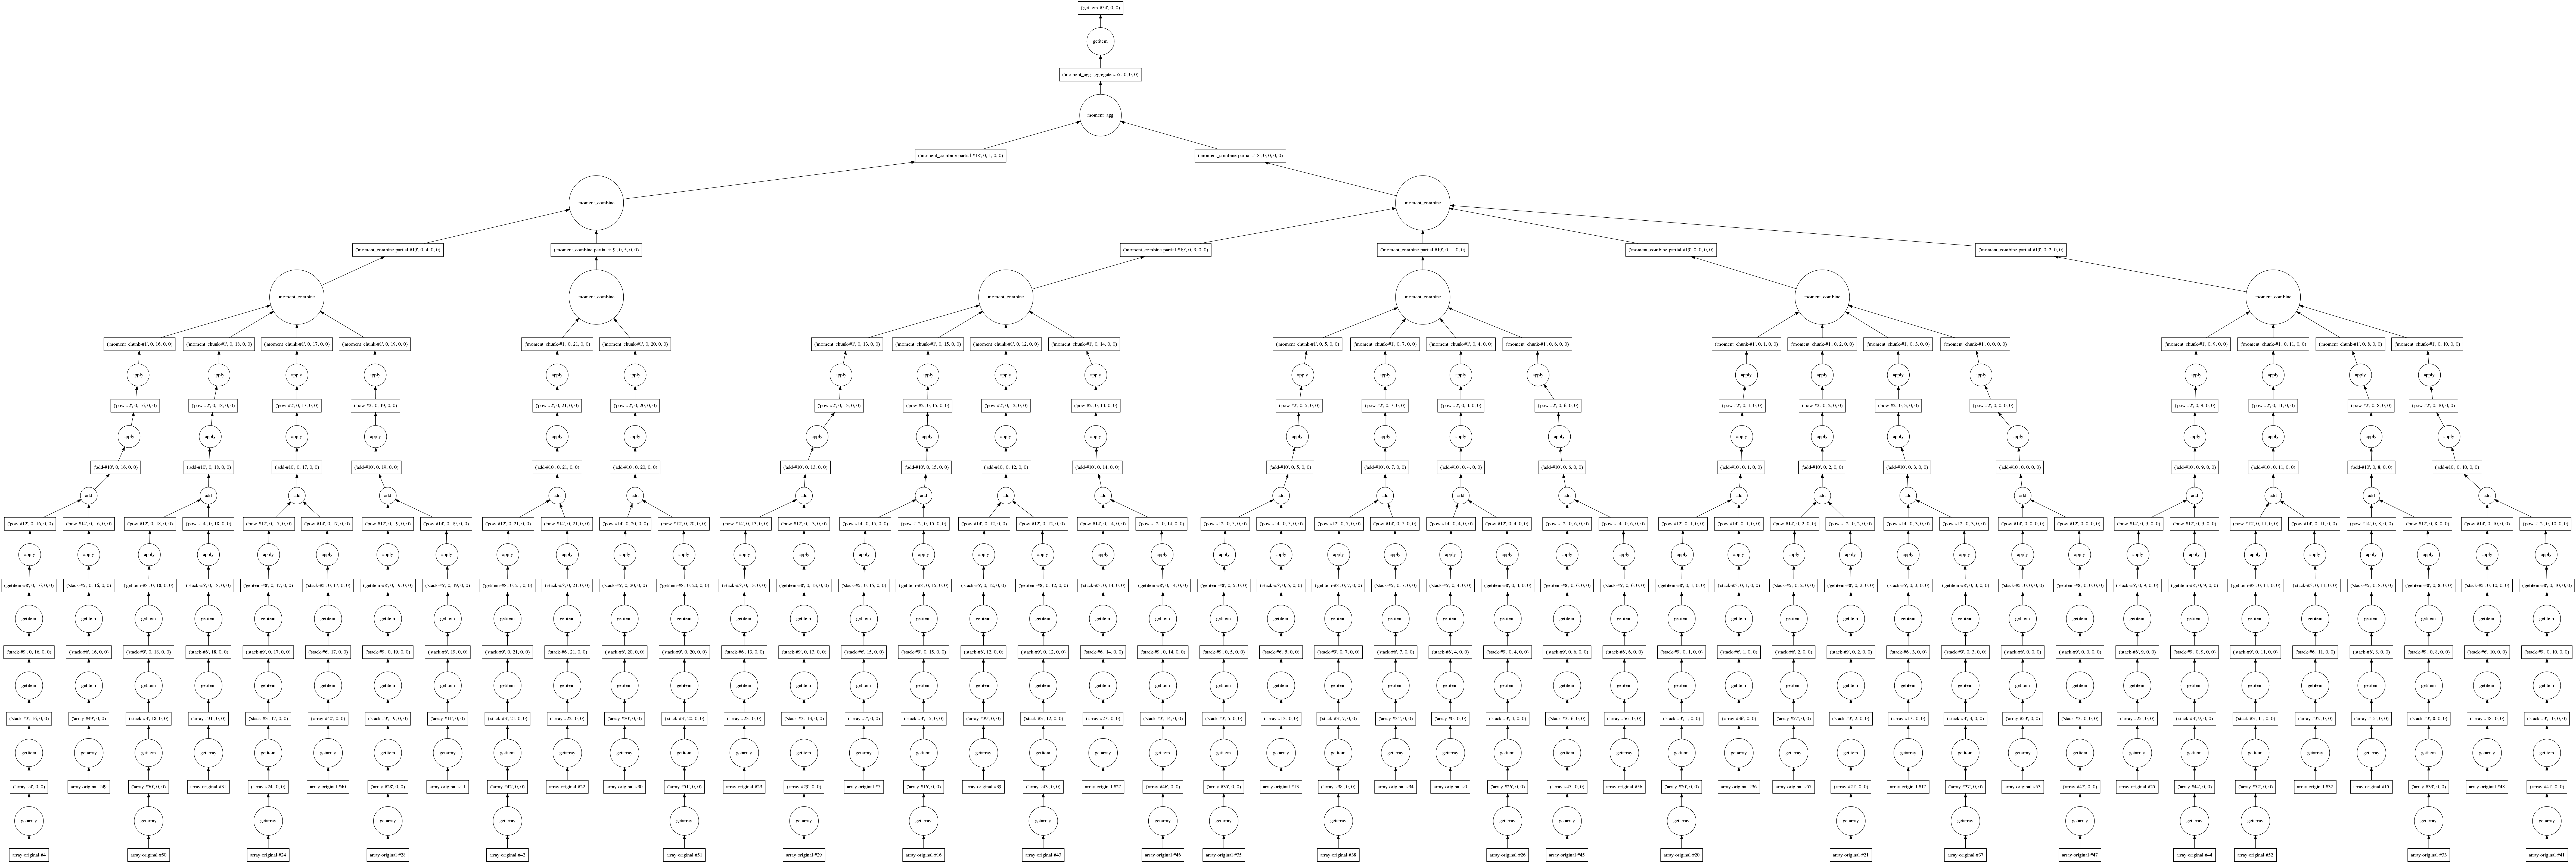

In [53]:
wspd_var_cube[0].core_data().visualize()

In [65]:
sample = wspd_var_cube[1]
sample.data

array([[ 4.06988239,  3.99408031,  3.932652  , ...,  5.00826883,
         5.88168764,  6.64356613],
       [ 3.85768604,  3.78441978,  3.79623914, ...,  4.64708662,
         5.44632959,  6.17845869],
       [ 3.68447375,  3.68833709,  3.6858089 , ...,  4.58165359,
         5.4146843 ,  6.24082947],
       ..., 
       [ 3.41037416,  3.38839936,  3.40271711, ...,  1.06602132,
         0.99407834,  0.92601323],
       [ 3.47229218,  3.41697216,  3.45572519, ...,  1.06126142,
         1.00275731,  0.94132179],
       [ 3.5187602 ,  3.53792357,  3.47245741, ...,  1.13931954,
         1.02430999,  0.95269448]], dtype=float32)

In [61]:
sample

<iris 'Cube' of wind_speed / (gray) (time: 3; grid_latitude: 999; grid_longitude: 1100)>

In [62]:
%%output size=450
gv.Dataset(cube[n],
           kdims=['time', 'grid_longitude', 'grid_latitude'], vdims=['wind_speed']
           ).to(gv.Image) * cl

ValueError: Image kdims must be between length 2 and 2.

In [ ]:
def slice_t(timestep):
    return wspd_var_cube[timestep]

In [40]:
wspd_var_cube[0].core_data().compute()

array([[  3.19961119,   3.26964426,   3.38727641, ...,  11.5609417 ,
         12.10436916,  10.61655807],
       [  3.0613966 ,   3.1797421 ,   3.30510759, ...,  10.25054836,
         10.74831581,   9.55935287],
       [  3.00374842,   3.08903217,   3.29073   , ...,   8.89729977,
          9.48556805,   8.65254402],
       ..., 
       [  2.80563402,   2.79502368,   2.75541973, ...,   1.30095387,
          1.30009103,   0.6790601 ],
       [  2.9025178 ,   2.76715302,   2.71731019, ...,   1.31706452,
          1.33638668,   0.69456911],
       [  2.85464358,   2.87417889,   2.84238553, ...,   1.41323352,
          1.37090123,   0.70775312]], dtype=float32)

In [ ]:
t_dim = hv.Dimension('time', cube.coord('time').points)

In [70]:
wspd_dataset = gv.Dataset(sample,
                          kdims=['time', 'grid_longitude', 'grid_latitude'],
                          vdims=['wind_speed'])
wspd_dataset

:Dataset   [time,grid_longitude,grid_latitude]   (wind_speed)

:HoloMap   [time]
   :Overlay
      .Image.I     :Image   [grid_longitude,grid_latitude]   (wind_speed)
      .Coastline.I :Feature   [Longitude,Latitude]
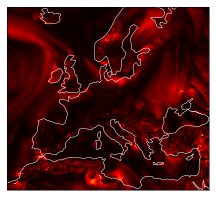

distributed.client - WARNING - Client report stream closed to scheduler


In [72]:
wspds = wspd_dataset.to(gv.Image, ['grid_longitude', 'grid_latitude']) * cl
wspds

### Compute results

In [ ]:
wspd_var_data = wspd_var_cube.data

In [ ]:
wdir_var_data = wdir_var_cube.data